# Getting started: Moving Horizon Estimation

In this Jupyter Notebook we illustrate the core functionalities of **do mpc**.

We start by importing the required modules, most notably `do_mpc`. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# Add to path:
import sys
sys.path.append('../../')

# Import do_mpc package:
import do_mpc

## Creating the model

First, we need to decide on the model type. For the given example, we are working with a continuous model.

In [3]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model(model_type)

### Model variables

The next step is to define the model variables. It is important to define the variable type, name and optionally shape (default is scalar variable). 


In [4]:
phi_1 = model.set_variable(var_type='_x', var_name='phi_1', shape=(1,1))
phi_2 = model.set_variable(var_type='_x', var_name='phi_2', shape=(1,1))
phi_3 = model.set_variable(var_type='_x', var_name='phi_3', shape=(1,1))
# Variables can also be vectors:
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1))
# Two states for the desired (set) motor position:
phi_m_1_set = model.set_variable(var_type='_u', var_name='phi_m_1_set')
phi_m_2_set = model.set_variable(var_type='_u', var_name='phi_m_2_set')
# Two additional states for the true motor position:
phi_1_m = model.set_variable(var_type='_x', var_name='phi_1_m', shape=(1,1))
phi_2_m = model.set_variable(var_type='_x', var_name='phi_2_m', shape=(1,1))

### Model measurements

In [5]:
# State measurements
phi_1_meas = model.set_meas('phi_1_meas', phi_1)
phi_2_meas = model.set_meas('phi_2_meas', phi_2)
phi_3_meas = model.set_meas('phi_3_meas', phi_3)

# Input measurements
phi_m_1_set_meas = model.set_meas('phi_m_1_set_meas', phi_m_1_set)
phi_m_2_set_meas = model.set_meas('phi_m_2_set_meas', phi_m_2_set)

### Model parameters

Next we **define parameters**. Known values can and should be hardcoded but with robust MPC in mind, we define uncertain parameters explictly. We assume that the inertia is such an uncertain parameter and hardcode the spring constant and friction coefficient.

In [6]:
# As shown in the table above, we can use Long names or short names for the variable type.
Theta_1 = model.set_variable('parameter', 'Theta_1') 
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

### Right-hand-side equation
Finally, we set the right-hand-side of the model by calling `model.set_rhs(var_name, expr)` with the `var_name` from the state variables defined above and an expression in terms of $x, u, z, p$. 

In [7]:
model.set_rhs('phi_1', dphi[0])
model.set_rhs('phi_2', dphi[1])
model.set_rhs('phi_3', dphi[2])

For the vector valued state `dphi` we need to concatenate symbolic expressions. We import the symbolic library CasADi: 

In [8]:
from casadi import *

In [9]:
dphi_next = vertcat(
    -c[0]/Theta_1*(phi_1-phi_1_m)-c[1]/Theta_1*(phi_1-phi_2)-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi_2-phi_1)-c[2]/Theta_2*(phi_2-phi_3)-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi_3-phi_2)-c[3]/Theta_3*(phi_3-phi_2_m)-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next)

In [10]:
tau = 1e-2 
model.set_rhs('phi_1_m', 1/tau*(phi_m_1_set - phi_1_m))
model.set_rhs('phi_2_m', 1/tau*(phi_m_2_set - phi_2_m))

The model setup is completed by calling `model.setup_model()`:

In [11]:
model.setup_model()

After calling `model.setup_model()` we cannot define further variables etc.

## Configuring the Moving Horizon Estimator

In [12]:
mhe = do_mpc.estimator.mhe(model, ['Theta_1'])

### MHE parameters:

In [13]:
setup_mhe = {
    't_step': 0.1,
    'n_horizon': 10,
    'store_full_solution': True,
    'meas_from_data': True
}
mhe.set_param(**setup_mhe)

### Cost Function

In [14]:
y_meas = mhe.vars['_y_meas']
y_calc = mhe.vars['_y_calc']

dy = y_meas.cat-y_calc.cat
obj = dy.T@np.diag(np.array([1,1,1,20,20]))@dy

x_0 = mhe.vars['_x']
x_prev = mhe.vars['_x_prev']
p_0 = mhe.vars['_p_est']
p_prev = mhe.vars['_p_prev']

dx = x_0.cat - x_prev.cat
dp = p_0.cat - p_prev.cat

arrival_cost = 1e-4*dx.T@dx + 1e-4*dp.T@dp


mhe.set_objective(obj, arrival_cost)

### Fixed parameters

In [15]:
p_template_mhe = mhe.get_p_template()

In [16]:
def p_fun_mhe(t_now):
    p_template_mhe['Theta_2'] = 2.25e-4
    p_template_mhe['Theta_3'] = 2.25e-4
    return p_template_mhe

In [17]:
mhe.set_p_fun(p_fun_mhe)

### Bounds

In [18]:
mhe.bounds['lower','_u', 'phi_m_1_set'] = -2*np.pi
mhe.bounds['lower','_u', 'phi_m_2_set'] = -2*np.pi
mhe.bounds['upper','_u', 'phi_m_1_set'] = 2*np.pi
mhe.bounds['upper','_u', 'phi_m_2_set'] = 2*np.pi

mhe.bounds['lower','_p_est', 'Theta_1'] = 1e-5
mhe.bounds['upper','_p_est', 'Theta_1'] = 1e-3

### Setup

In [19]:
mhe.setup()

## Configuring the Simulator
In many cases a developed control approach is first tested on a simulated system. **do mpc** responds to this need with the `do_mpc.simulator` class. The `simulator` uses state-of-the-art DAE solvers, e.g. Sundials [CVODE](https://computing.llnl.gov/projects/sundials/cvode) to solve the DAE equations defined in the supplied `do_mpc.model`. This will often be the same model as defined for the `optimizer` but it is also possible to use a more complex model of the same system.

In this section we demonstrate how to setup the `simulator` class for the given example. We initilize the class with the previously defined `model`:

In [20]:
simulator = do_mpc.simulator(model)

### Simulator parameters

Next, we need to parametrize the `simulator`. Please see the API documentation for `simulator.set_param()` for a full description of available parameters and their meaning. Many parameters already have suggested default values. Most importantly, we need to set `t_step`. We choose the same value as for the `optimizer`.

In [21]:
# Instead of supplying a dict with the splat operator (**), as with the optimizer.set_param(),
# we can also use keywords (and call the method multiple times, if necessary):
simulator.set_param(t_step = 0.1)

### Uncertain parameters
In the `model` we have defined the inertia of the masses as parameters, for which we have choosen multiple scenarios in the `optmizer`. The `simulator` is now parametrized to simulate with the "true" values at each timestep. In the most general case, these values can change, which is why we need to supply a function that can be evaluted at each time to obtain the current values. 
**do mpc** requires this function to have a specific return structure which we obtain first by calling:

In [22]:
p_template_sim = simulator.get_p_template()

This object is a CasADi structure:

which can be indexed with the following keys:

In [23]:
p_template_sim.keys()

['default', 'Theta_1', 'Theta_2', 'Theta_3']

We need to now write a function which returns this structure with the desired numerial values. For our simple case:

In [24]:
def p_fun_sim(t_now):
    p_template_sim['Theta_1'] = 2.25e-4
    p_template_sim['Theta_2'] = 2.25e-4
    p_template_sim['Theta_3'] = 2.25e-4
    return p_template_sim

This function is now supplied to the `simulator` in the following way:

In [25]:
simulator.set_p_fun(p_fun_sim)

### Setup
Similarly to the `optimizer` we need to call `simulator.setup()` to finalize the setup of the simulator.

In [26]:
simulator.setup()

## Creating the control loop
In theory, we could now also create an estimator but for this concise example we just assume direct state-feedback. This means we are now ready to setup and run the control loop. 
The control loop consists of running the optimizer with the current state ($x_0$) to obtain the current control input ($u_0$) and then running the simulator with the current control input ($u_0$) to obtain the next state.

As discussed before, we setup a controller for regulating a triple-mass-spring system. To show some interesting control action we choose an arbitrary initial state $x_0\neq 0$:

In [27]:
x0 = np.pi*np.array([1, 1, -1.5, 1, -5, 5, 0, 0]).reshape(-1,1)

In [28]:
x0_mhe = x0*(1+0.5*np.random.randn(8,1))

and use the `.set_initial_state()` method to set the initial state (which also calls `optimizer.set_initial_guess()`.

In [29]:
simulator.set_initial_state(x0, reset_history=True)
mhe.set_initial_state(x0_mhe ,p_est0=np.array([1e-4]), reset_history=True)

### Setting up the Graphic
To investigate the controller performance **AND** the MPC predictions, we are using the **do mpc** `graphics` module. This versatile tool allows us to conveniently configure a user-defined plot based on Matplotlib and visualize the results stored in the `optimizer.data`, `simulator.data` (and if applicable `estimator.data`) objects. 

We start by importing matplotlib:

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

And initializing the `graphics module`:

In [31]:
graphics = do_mpc.graphics()

Next, we create a `figure` and obtain its `axis` object. Matplotlib offers multiple alternative ways to obtain an `axis` object, e.g. [subplots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html), [subplot2grid](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot2grid.html), or simply [gca](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html). We use `subplots`:

In [32]:
%%capture 
# We just want to create the plot and not show it right now. This "inline magic" surpresses the output.
fig, ax = plt.subplots(3, sharex=True, figsize=(16,9))
fig.align_ylabels()

fig_p, ax_p = plt.subplots(1, figsize=(16,4))

Most important API element for setting up the `graphics` module is `graphics.add_line`, which mimics the API of `model.add_variable`, except that we also need to pass an `axis`. 

Note that we are only configuring the `graphics` module without showing anything just yet.

In [33]:
%%capture
# Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
graphics.add_line(var_type='_x', var_name='phi_1', axis=ax[0])
graphics.add_line(var_type='_x', var_name='phi_2', axis=ax[0])
graphics.add_line(var_type='_x', var_name='phi_3', axis=ax[0])
ax[0].set_ylabel('angle \n position [rad]')

graphics.add_line(var_type='_x', var_name='dphi', axis=ax[1])
ax[1].set_ylabel('angular \n velocity [rad/s]')

# Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
graphics.add_line(var_type='_u', var_name='phi_m_1_set', axis=ax[2])
graphics.add_line(var_type='_u', var_name='phi_m_2_set', axis=ax[2])
ax[2].set_ylabel('motor \n angle [rad]')

ax[2].set_xlabel('time [s]')

graphics.add_line(var_type='_p', var_name='Theta_1', axis=ax_p)
graphics.add_line(var_type='_p', var_name='Theta_2', axis=ax_p)
graphics.add_line(var_type='_p', var_name='Theta_3', axis=ax_p)

### Running the simulator
We start investigating the **do mpc** simulator and the `graphics` package by simulating the autonomous system without control inputs ($u = 0$). This can be done as follows:

In [34]:
u0 = np.zeros((2,1))
def random_u(u0):
    u_next = (0.5-np.random.rand(2,1))*np.pi
    switch = np.random.rand() >= 0.8
    u0 = (1-switch)*u0 + switch*u_next
    return u0

In [35]:
%%capture
for i in range(50):
    u0 = random_u(u0)
    y0 = simulator.make_step(u0)*(1+0.1*np.random.randn(model.n_y,1))
    x0 = mhe.make_step(y0)

We can visualize the resulting trajectory with the pre-defined graphic:

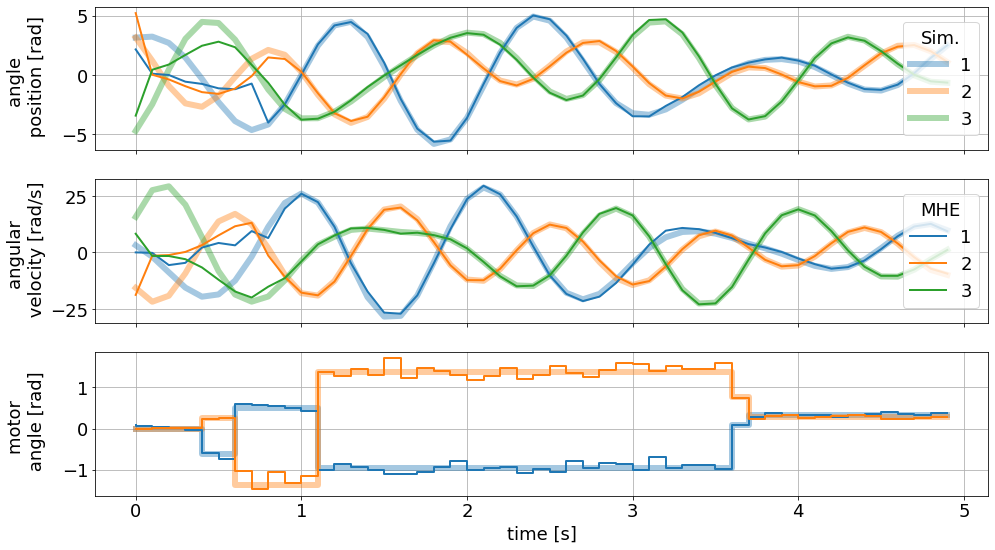

In [36]:
graphics.reset_axes()
sim_lines = graphics.plot_results(simulator.data, linewidth = 6, alpha =0.4, linestyle='-')
ax[0].legend(sim_lines[:3], '123', title='Sim.', loc='center right')
mhe_lines = graphics.plot_results(mhe.data, linewidth = 2, alpha = 1, linestyle='-')
ax[1].legend(mhe_lines[:3], '123', title='MHE', loc='center right')
# Show the figure:
fig

Parameter estimation:

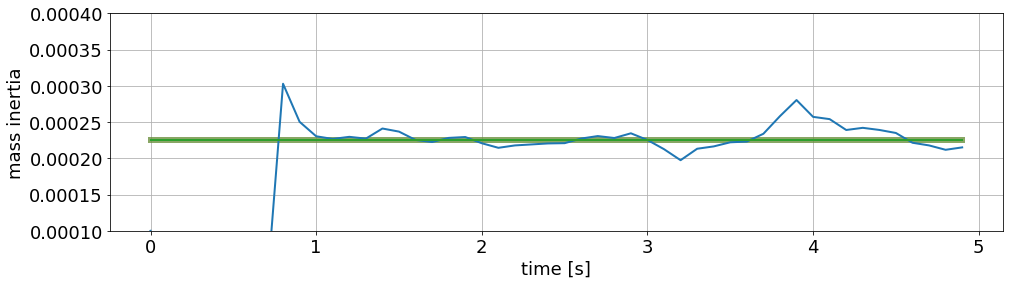

In [37]:
ax_p.set_ylim(1e-4, 4e-4)
ax_p.set_ylabel('mass inertia')
ax_p.set_xlabel('time [s]')
fig_p

Thank you, for following through this short example on how to use **do mpc**. We hope you find the tool and this documentation useful.

We suggest that you have a look at the API documentation for further details on the presented modules, methods and functions.

We also want to emphasize that we skipped over many details, further functions etc. in this introduction. Please have a look at our more complex examples to get a better impression of the possibilities with **do mpc**.